# Tutorial <span style='color:red'>?</span>: Lorentz Transmission Electron Microscopy

Lorentz Transmission Electron Microscopy (LTEM) is a useful technique to image magnetic structures that exist in thin magnetic samples. In this tutorial, the Ubermag micromagnetic simulation software is used to create 3-Dimensional magnetic structure, from which LTEM of defocused images and electron holography can be obtained. 

It is worth noting that as the Lorentz force depends on ${\bf v}\times {\bf B}$ there is no force along direction of travel of the electron beam, hence Lorentz microscopy is only sensitive to the in-plane magnetic field i.e. the magnetic field perpendicular to the beam.

## LTEM Reference frame

In `mag2exp` the experimental reference for LTEM is defined by the electron beam propagating along the <span style='color:Red'> negative  </span> $z$ direction.
<span style='color:Red'> Figure?  </span>

## The micromagnetic simulation

A micromagnetic simulation can be set up using <code>Ubermag</code> to obtain a 3-Dimentional magntic structure.

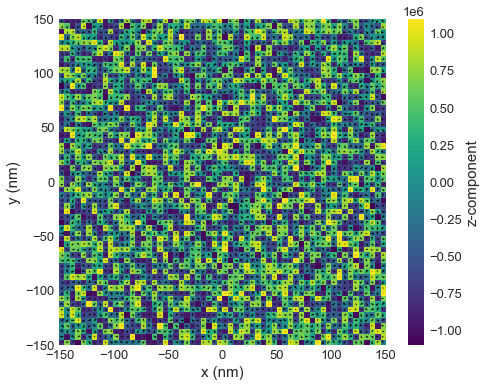

In [1]:
%matplotlib inline
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import ubermagutil.units as uu
np.random.seed(1)

region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T') 
                 + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1)) 
                 + mm.Demag()
                 + mm.Zeeman(H=(0, 0, 2e5)))

Ms = 1.1e6

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('z').mpl.plot()

Relax the system and plot its magnetisation.

Running OOMMF (DockerOOMMFRunner) [2021/07/26 16:53]... (17.6 s)


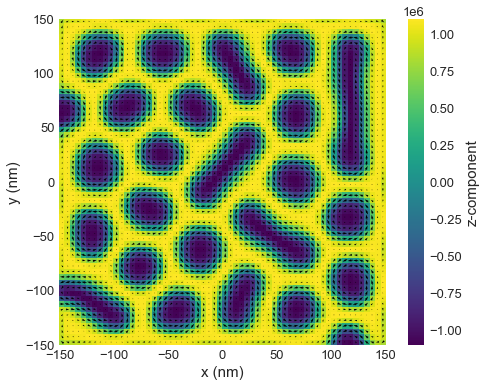

In [2]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl.plot()

Now we have a magnetisation texture we can compute the LTEM defocus and holography patterns.

## Computing LTEM images

We can use the <code><span style='color:Red'>mag2exp</span></code> package to first calculate the phase of the electrons as they propagate through the sample along the $z$ direction.
The phase shift experienced by the electrons as they travel through the sample due to the magnetic contribution is
\begin{equation} \label{Eq:C7:phase_shift_mag}
    \phi_m (x,y)=-\frac{2\pi e}{h}\int_{-\infty}^\infty A_z (x,y,z)\, {\rm d}z,
\end{equation}
where $h$ is Planck's constant and ${\bf A}$ is the magnetic vector potential, as defined in Ref. \[[1](https://global.oup.com/academic/product/electricity-and-magnetism-volume-2-9780199645435?cc=gb&lang=en&)\].

The calculation of the phase is performed in Fourier space using
\begin{equation} \label{Eq:C7:FT_M}
    \widetilde{\phi}_m (k_x,k_y)=\frac{i e \mu_0 k_\perp^2}{h} \frac{\left[ \widetilde{\bf M}_I(k_x,k_y)\times {\bf k}_\perp \right] _z}{\left( k_\perp^2 + k_c^2 \right)^2},
\end{equation}
where ${\bf M}_I$ is the integrated magnetisation along the path of the electron beam, $\mu_0$ is the vacuum permeability, and $k$ is the k-vector in Fourier space, as given in Ref \[[2](https://www.tandfonline.com/doi/abs/10.1080/0141861031000066166)\].
To avoid singularities in Fourier space, a Tikhonov filter is used where $1/k^2$ is replaced by $k^2/(k^2+k_c^2)$ where $k_c$ is the radius of the filter.

The function `mag2exp.ltem_phase` is used to calculate the phase and Fourier transform of the phase. In this function the radius of the Tikhonov filter is defined by `kcx` and `kcy` in units of pixels.

In [3]:
import mag2exp
kcx = kcy = 0.1  # Pixels
phase, ft_phase = mag2exp.ltem.phase(system.m, kcx=kcx, kcy=kcy)

The phase (`phase`) and its Fourier transform (`ft_phase`) are `discretisedfield` objects hence the built in plotting functions can be used to view them. Both the phase and its Fourier transform are complex quantities, hence to view them either the real or imaginary part has to be selected before plotting.

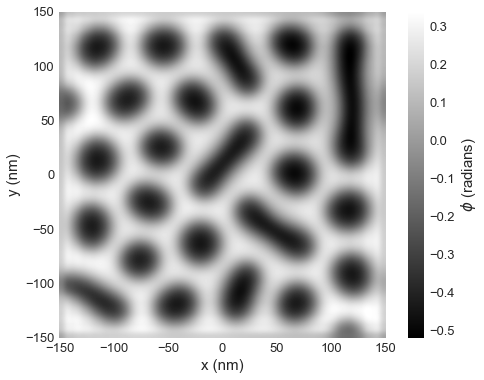

In [4]:
phase.real.mpl.scalar(cmap='gray',
                      interpolation='spline16',
                      colorbar_label=r'$\phi$ (radians)')

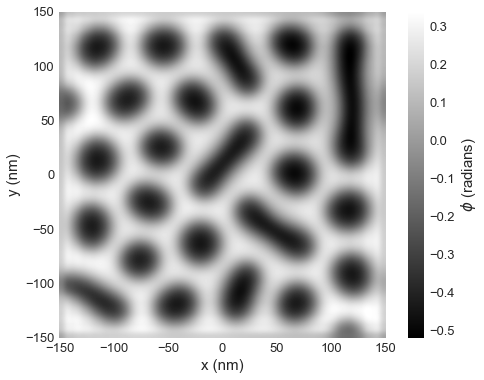

In [5]:
mag2exp.quick_plots.ltem_phase(system.m)

This example shows how to use the conjugate property to plot $\left\vert\widetilde{\phi}_m\right\vert^2$ with the Tikhonov filter indicated my the small red circle.

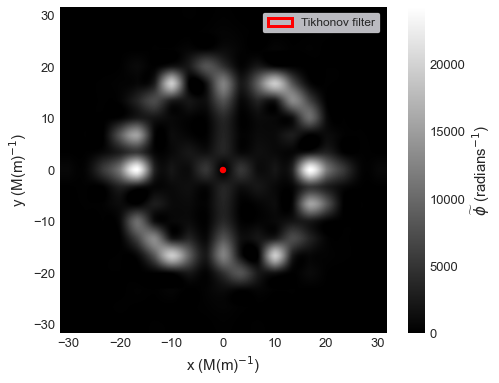

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

centre_region = df.Region(p1=(-30e6, -30e6, 0), p2=(30e6, 30e6, 1))

fig, ax = plt.subplots()
(ft_phase.conjugate * ft_phase)[centre_region].plane('z').real.mpl.scalar(
    ax=ax, cmap='gray', interpolation='spline16', colorbar_label=r'$\widetilde{\phi}$ (radians$^{-1}$)')

multiplier = uu.si_max_multiplier(ft_phase.mesh.region.edges)
ax.add_patch(Ellipse(xy=(0, 0),
                     width=ft_phase.mesh.cell[0] * kcx * 2 / multiplier,
                     height=ft_phase.mesh.cell[1] * kcy * 2 / multiplier,
                     edgecolor='red',
                     facecolor='none',
                     linewidth=3,
                     label='Tikhonov filter'))
ax.legend(frameon=True);

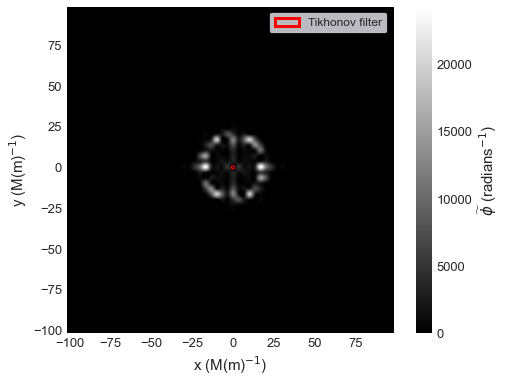

In [7]:
mag2exp.quick_plots.ltem_ft_phase(system.m)

### Defocused Imaging

The wavefunction of the electron beam as it exits the specimen can be calculated using the phase
\begin{equation}
\psi_0 = e^{i\phi_m}.
\end{equation}

Out-of-focus images can be simulated by propagating the wavefunction through free-space by a distance $\Delta f$, known as the defocus, using Contrast Transfer Function $T$ Ref. \[[3](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.49.6800)\]

\begin{align}
    \psi_{\Delta f} &= {\psi}_{0} * T, \label{Eq:C7:CTF_Wave} \\
    \widetilde{\psi}_{\Delta f} &= \widetilde{\psi}_0 \widetilde{T}({\bf k}), \label{Eq:C7:FT_CTF_Wave}\\
    \widetilde{\psi}_{\Delta f} &= \widetilde{\psi}_0 e^{2 i \pi k^2 (-\frac{1}{2}\lambda \Delta f + \frac{1}{4} C_s \lambda^3 k^2)}. \label{Eq:C7:FT_CTF_Wave_full}
\end{align}
$\lambda$ is the relativistic wavelength of the electrons and $C_s$ is the spherical aberration of the electromagnetic lens.

The image at a specific defocus is then given by
\begin{equation} \label{Eq:C7:Intensity}
    I_{\Delta f} = \left\vert\psi_{\Delta f}\right\vert^2.
\end{equation}

The intensity of an in-focus image is $I=\left\vert\psi_0\right\vert^2=1$ and so the image appears featureless however magnetic contrast appears when you go out-of-focus.

The `mag2exp.ltem_defocus_image` function calculates the image at a specific <code>df_length</code>, given the spherical aberration `cs`, and accelerating voltage of the electrons `voltage`.

In [8]:
defocus = mag2exp.ltem.defocus_image(phase, voltage=300e3, cs=8000, df_length=-0.4e-3)

The defocus image can then be plot using the inbuilt functions.

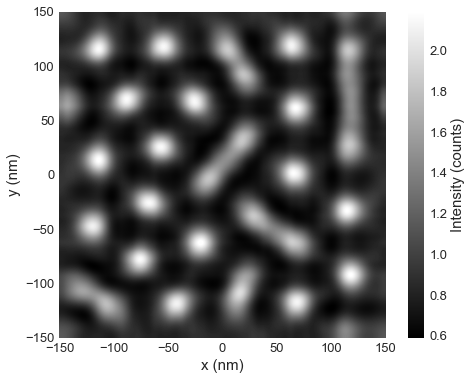

In [9]:
defocus.mpl.scalar(cmap='gray',
                   interpolation='spline16',
                   colorbar_label='Intensity (counts)')

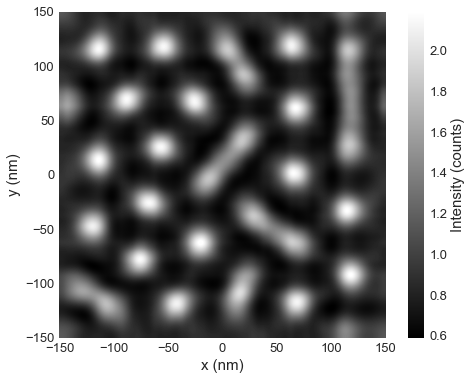

In [10]:
mag2exp.quick_plots.ltem_defocus(system.m, voltage=300e3, cs=8000, df_length=-0.4e-3)

As a rule of thumb, the magnetic feature will only be seen experimentally using this technique if it gives a contrast greater than 1%. The image contrast is defined as
\begin{equation}
{\rm contrast} = \frac{I_{\rm max}-I_{\rm min}}{I_{\rm max} + I_{\rm min}}
\end{equation}
where $I_{\rm max}$ and $I_{\rm max}$ are, respectively, the maximum and minimum intensities of the image.

In [11]:
contrast = (defocus.array.max() - defocus.array.min()) / (defocus.array.max() + defocus.array.min())
print(f'Contrast: {contrast*100:.1f}%')

Contrast: 57.6%


### Off-axis electron holography

Off-axis electron holography the phase of the electrons is recovered directly and may be compared with the phase calculated.

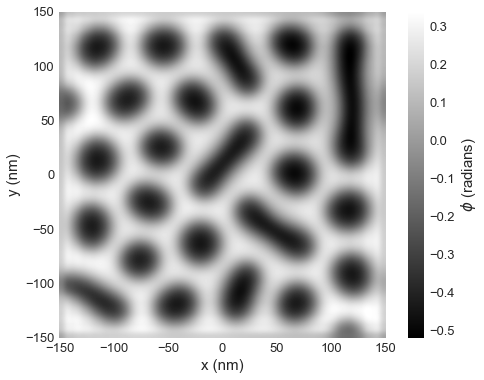

In [12]:
phase.real.mpl.scalar(cmap='gray',
                      interpolation='spline16',
                      colorbar_label=r'$\phi$ (radians)')

### Integrated magnetic flux density

From the phase of the electrons determined other useful quantities can be calculated such as the integrated magnetic flux density ${\bf B}_\perp$. This can be used to compare against the results from electron holography, as it calculates the phase and hence ${\bf B}_\perp$ is reconstructed. The ${\bf B}_\perp$ can be calculated Ref. \[[1](https://global.oup.com/academic/product/electricity-and-magnetism-volume-2-9780199645435?cc=gb&lang=en&)\] from
\begin{equation} \label{Eq:C7:B_perp}
t{\bf B}_\perp =\frac{\Phi_0}{\pi}\begin{pmatrix} -\partial/\partial y \\ \partial/\partial x \end{pmatrix} \phi_m ,
\end{equation}
where $\Phi_0$ is the magnetic flux quantum and $t$ is the thickness of the sample.

In [13]:
imf = mag2exp.ltem.integrated_magnetic_flux_density(phase)

The `mpl.plot`, `mpl.vector`, and `mpl.scalar` functions can be used to plot this 2-Dimentional field. Colour plots use the HSV colour map.

In [19]:
imf.mpl.scalar()

ValueError: Cannot plot self.data.dim=2 field.

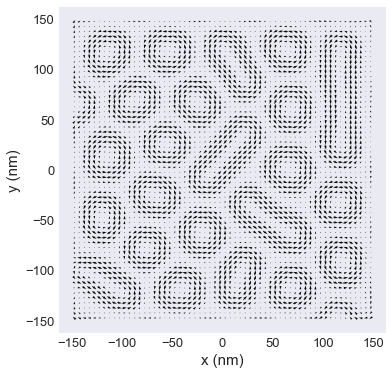

In [22]:
imf.mpl.plot_simplified(scalar_kwargs=)

ValueError: Cannot plot self.data.dim=2 field.

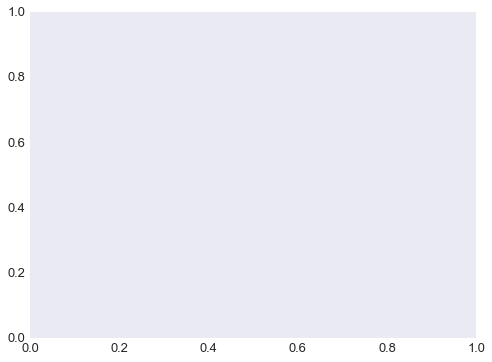

In [14]:
fig, ax = plt.subplots()
imf.mpl.scalar(ax=ax, interpolation='spline16', lightness_clim=[0,0.5], colorbar=False)
imf.plane('z', n=(30, 30)).mpl_vector(ax=ax, use_color=False, color='w')
#ax_ins = ax.inset_axes([0,0,1e-9,1e-9], transform=ax.transData)
ax_ins = fig.add_axes([0.25,0.15,.1,.1])
ax_ins.imshow(rgb_colourwheel())
ax_ins.axis('off')
ax_ins.arrow(100,100,0,-60, width=5, fc="w", ec="w")
ax_ins.arrow(100,100,60,0, width=5, fc="w", ec="w")
ax_ins.annotate(r'$m_x$', (110, 160), c="w")
ax_ins.annotate(r'$m_y$', (10, 90), c="w")

The contours of the integrated magnetic flux density can be plotted using `mpl.contour`.

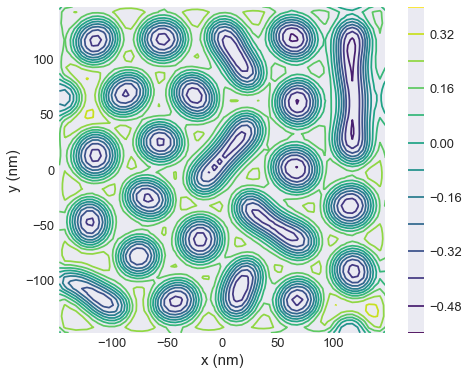

In [23]:
phase.real.mpl.contour(levels=10)